In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

elevated_perfusion
0    13
1    10
Name: count, dtype: int64


Text(0.5, 0, 'Elevated perfusion')

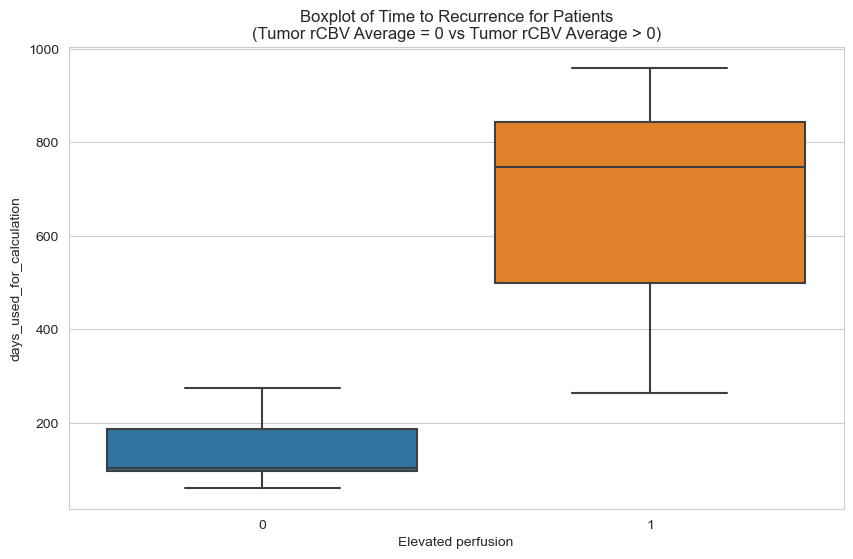

In [2]:
# use pandas to read excel file
patient_data = pd.read_excel('cleaned_rcbv_measurements.xlsx')

# Convert the necessary columns to numeric for analysis
patient_data['tumor_rcbv_average'] = pd.to_numeric(patient_data['tumor_rcbv_average'])
patient_data['time_to_recurrence_(days)'] = pd.to_numeric(patient_data['time_to_recurrence_(days)'])
patient_data['days_used_for_calculation'] = pd.to_numeric(patient_data['days_used_for_calculation'])

# Create a new binary feature
patient_data['elevated_perfusion'] = np.where(patient_data['rcbv_ratio'] > 1.5, 0, 1)
print(patient_data['elevated_perfusion'].value_counts())

# create new feature, relatve tumor_rcbv_variance 
patient_data['tumor_rcbv_cv'] = patient_data['tumor_rcbv_stdev'] / patient_data['tumor_rcbv_average']
# convert NaN to 0
patient_data['tumor_rcbv_cv'] = patient_data['tumor_rcbv_cv'].fillna(0)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=patient_data, x='elevated_perfusion', y='days_used_for_calculation')
plt.title('Boxplot of Time to Recurrence for Patients\n(Tumor rCBV Average = 0 vs Tumor rCBV Average > 0)')
plt.xlabel('Elevated perfusion')

In [3]:
# print the number of patients for each treatment type
print(patient_data.head())
print(patient_data['treatment'].value_counts())
print(patient_data['operation'].value_counts())
print(patient_data['sex'].value_counts())

  sex        age patient_id  tumor_rcbv_average  tumor_rcbv_median  \
0   F  81.793292  patient 1         1144.011782        1117.754272   
1   F  65.075975  patient 2         1085.625696        1099.082886   
2   M  34.877481  patient 3          171.714627         170.293167   
3   M  52.629706  patient 4          129.068512         129.553467   
4   F  61.984942  patient 5          585.621115         595.121826   

   tumor_rcbv_stdev  normal_rcbv_average  normal_rcbv_median  \
0        365.946212           420.871934          384.203613   
1        146.205574           315.452425          291.418610   
2         28.028336            67.844466           65.218544   
3         26.585282            64.307625           62.522053   
4        188.641487           235.070089          236.974869   

   normal_rcbv_stdev  rcbv_ratio  time_to_recurrence_(days)  \
0         197.876047    2.718195                       60.0   
1          78.201336    3.441488                      186.0   
2    

In [4]:
# Load the second dataset
treatment_data_path = 'treatment.csv'
treatment_data = pd.read_csv(treatment_data_path)

In [6]:
treatment_data['rectime_days'] = treatment_data['rectime'] * 1.083  # calculated from experimental data

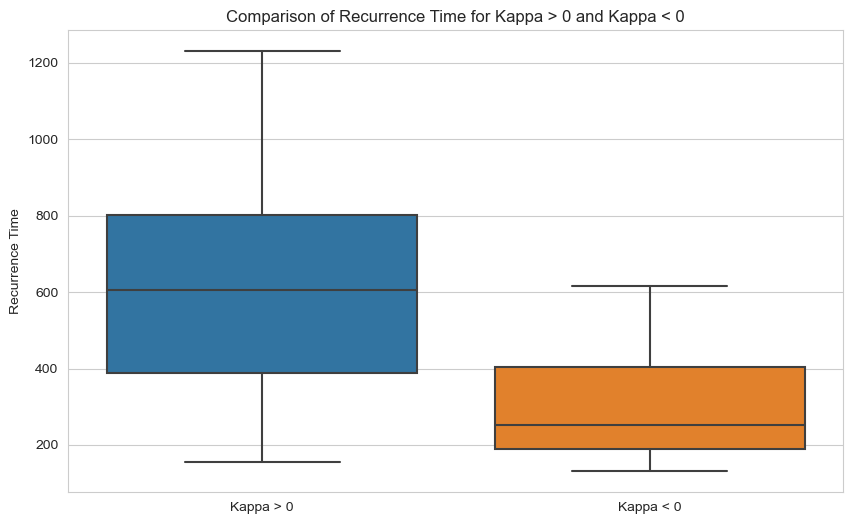

In [9]:
# Filtering the data into two groups based on kappa. also make sure that r_d = 0.25
group1_kappa_positive = treatment_data[(treatment_data['kappa'] > 0) & (treatment_data['r_d'] == 0.25)]['rectime_days']
group2_kappa_negative = treatment_data[(treatment_data['kappa'] < 0) & (treatment_data['r_d'] == 0.25)]['rectime_days']
# group1_kappa_positive = treatment_data[treatment_data['kappa'] > 0 & treatment_data['r_d'] == 0.25]['rectime_days']
# group2_kappa_negative = treatment_data[treatment_data['kappa'] < 0 & treatment_data['r_d'] == 0.25]['rectime_days']

# Preparing the data for plotting
boxplot_data_kappa = [group1_kappa_positive, group2_kappa_negative]
labels_kappa = ['Kappa > 0', 'Kappa < 0']

# Creating the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot_data_kappa)
plt.xticks([0, 1], labels_kappa)
plt.title('Comparison of Recurrence Time for Kappa > 0 and Kappa < 0')
plt.ylabel('Recurrence Time')
plt.show()


([<matplotlib.axis.XTick at 0x279e4e146d0>,
 [Text(0, 0, 'No elevated perfusion'),
  Text(1, 0, 'elevated perfusion'),
  Text(2, 0, 'Kappa > 0'),
  Text(3, 0, 'Kappa < 0')])

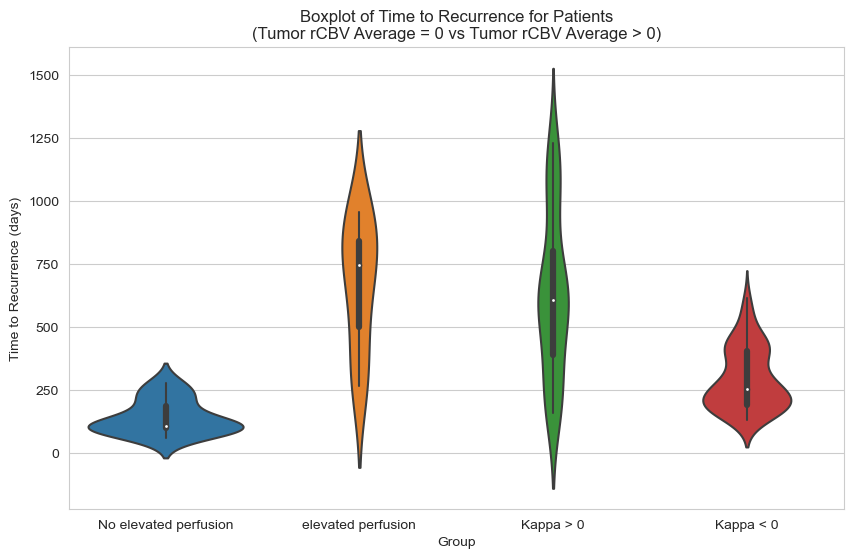

In [12]:
data_for_boxplot = [patient_data[patient_data['elevated_perfusion'] == 0]['days_used_for_calculation'],
                    patient_data[patient_data['elevated_perfusion'] == 1]['days_used_for_calculation']]

labels_rcbv = ['No elevated perfusion', 'elevated perfusion']
# plot all boxplots in the same axes
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_for_boxplot+boxplot_data_kappa)
plt.title('Boxplot of Time to Recurrence for Patients\n(Tumor rCBV Average = 0 vs Tumor rCBV Average > 0)')
plt.xlabel('Group')
plt.ylabel('Time to Recurrence (days)')
plt.xticks([0, 1, 2, 3], labels_rcbv+labels_kappa)

In [46]:
# Preprocess the data for Random Forest classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.linear_model import LinearRegression


# Selecting relevant features and target variable
features = ['sex', 'age', 'rcbv_ratio', 'operation']
target = 'days_used_for_calculation'

X = patient_data[features]
y = patient_data[target]
# Checking for missing values
missing_values = X.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)

Series([], dtype: int64)


In [47]:
from sklearn.preprocessing import FunctionTransformer

# Pipeline for numerical features
numeric_features = ['age', 'rcbv_ratio']

numeric_transformer = Pipeline(steps=[
    ('identity', FunctionTransformer())
    #('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_features = ['sex', 'operation']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_test = X
# y_train = y
# y_test = y
# Apply the transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape

((18, 4), (5, 4))

In [48]:
# Initialize the Linear Regression model
linear_regression = LinearRegression()

# Fit the model on the training data
linear_regression.fit(X_train_transformed, y_train)

# Make predictions on the testing data
y_pred = linear_regression.predict(X_test_transformed)

# Calculate and print the Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 66775.68358730202
Mean Absolute Error (MAE): 238.48336302023145


<Axes: xlabel='rcbv_ratio', ylabel='days_used_for_calculation'>

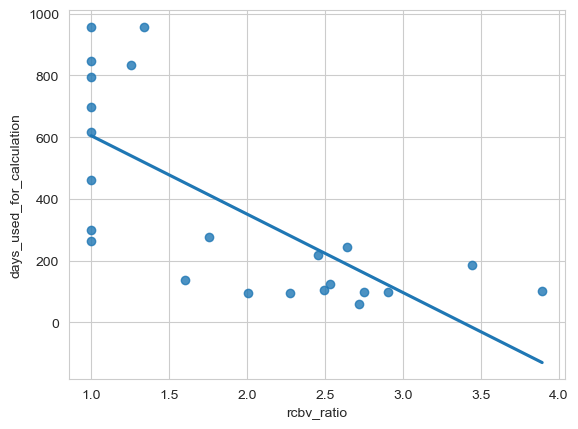

In [50]:
# linear regression plot using seaborn
sns.regplot(x='rcbv_ratio', y='days_used_for_calculation', ci=None, data=patient_data)

In [51]:
# Training the model
# Create the Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=10, random_state=0)

# Train the model
random_forest.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test_transformed)

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse, mae

(1415.8360000000007, 33.60000000000001)

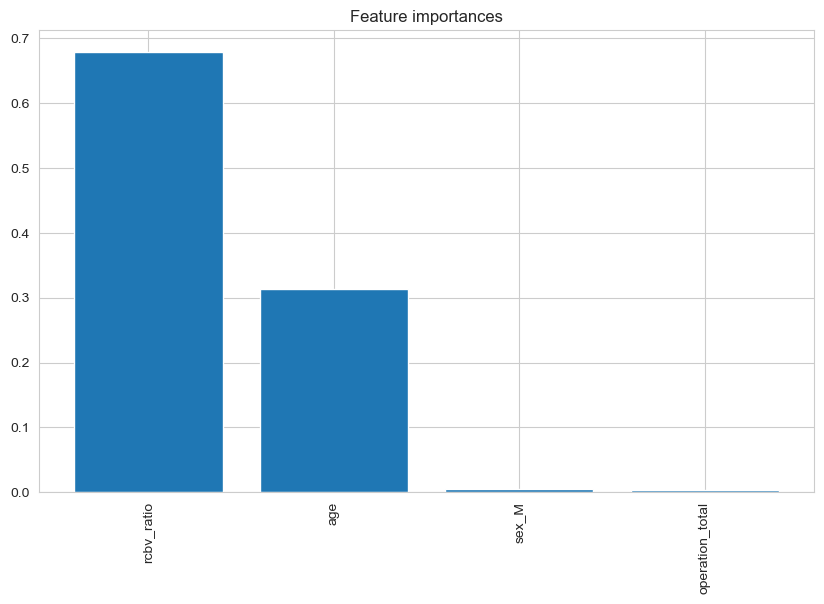

In [52]:
# Extract the feature importances from the trained model
importances = random_forest.feature_importances_

# For the categorical features
categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine the two lists
features = np.concatenate([numeric_features, categorical_features])

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances as a bar chart
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.show()

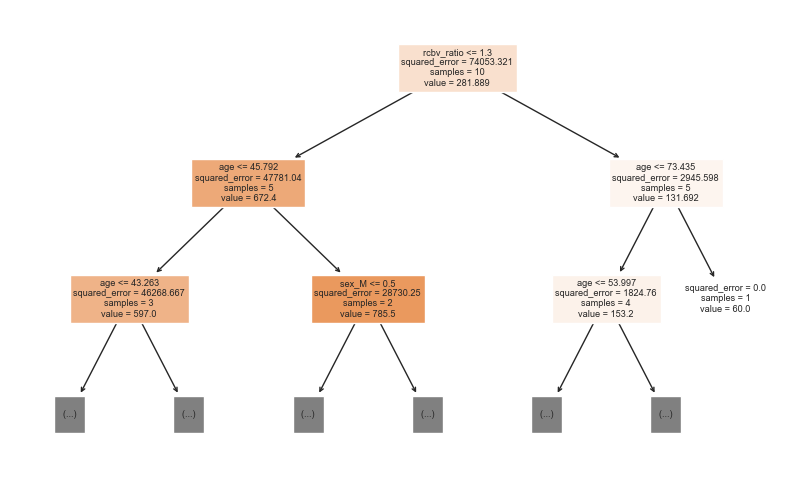

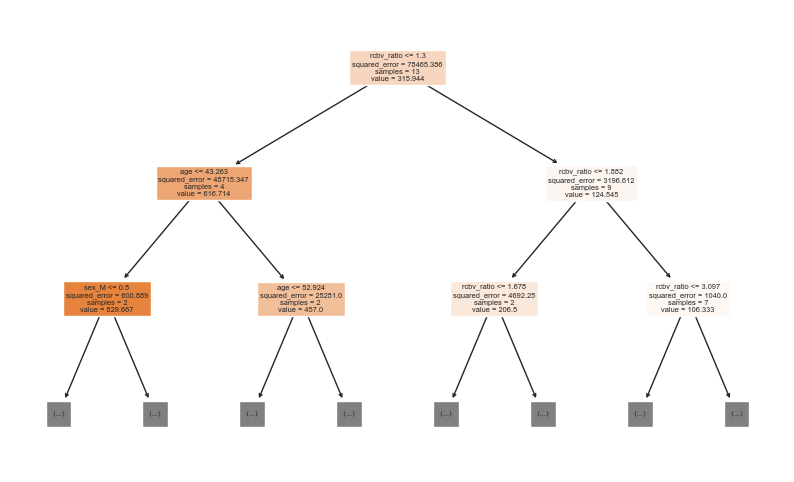

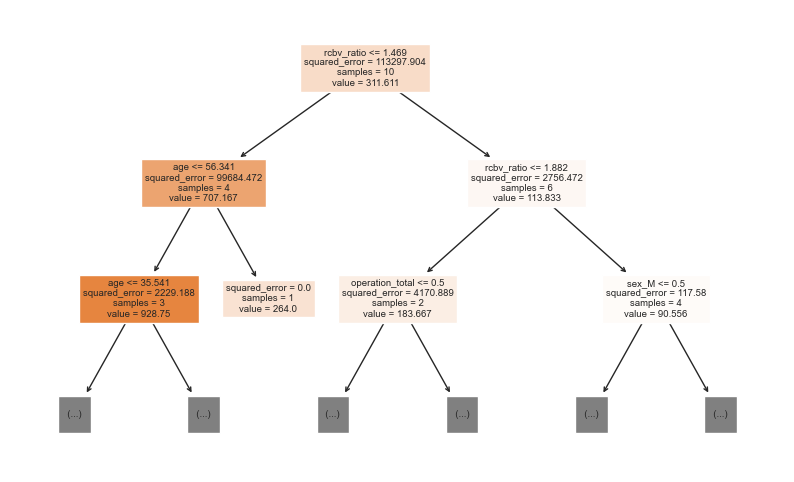

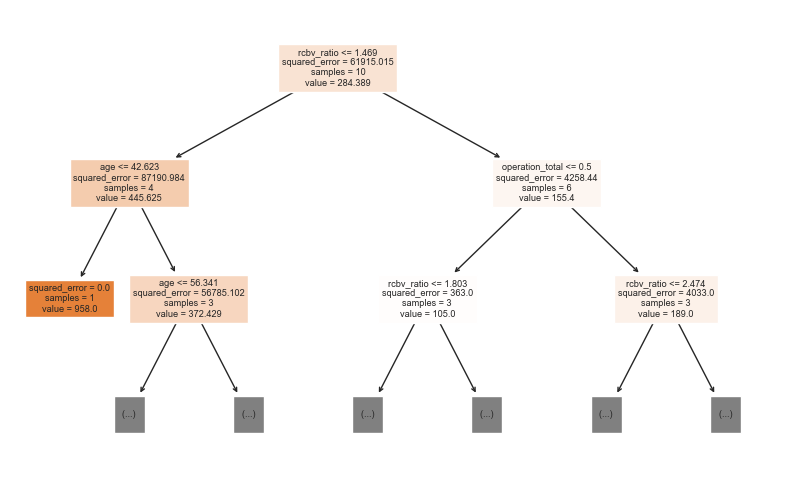

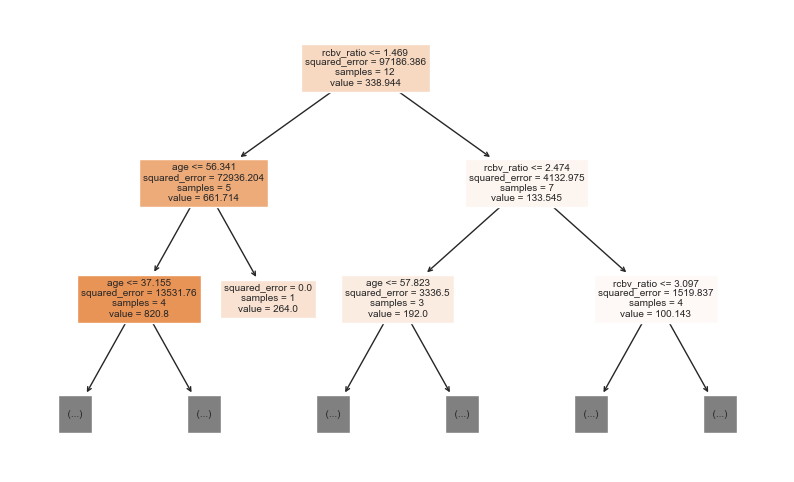

In [53]:
# plot the first tree of the random forest
from sklearn.tree import plot_tree

# Get the Random Forest model
model = random_forest
# Plot the first five trees
for i in range(5):
    plt.figure(figsize=(10, 6))
    plot_tree(model.estimators_[i], feature_names=list(features), filled=True, max_depth=2)
    plt.show()

# plt.savefig('tree_continuous_rcbv.png', dpi=300)

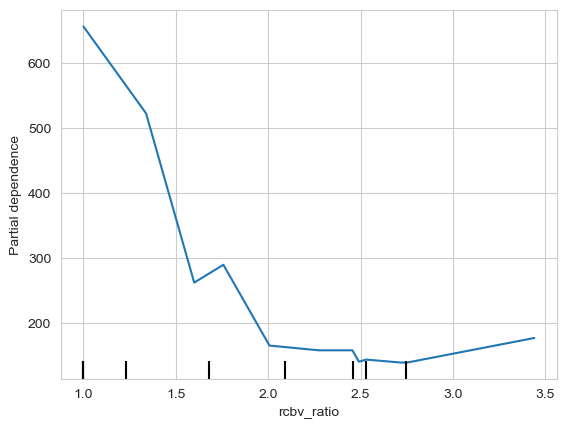

In [54]:
from sklearn.inspection import PartialDependenceDisplay

# Get the index of the rcbv_ratio feature in the transformed dataset
feature_idx = list(features).index('rcbv_ratio')

# Create the PartialDependenceDisplay
display = PartialDependenceDisplay.from_estimator(
    random_forest, X_train_transformed, features=[feature_idx], feature_names=features)

Mean Squared Error (MSE): 53337.49381428571
Mean Absolute Error (MAE): 147.5442857142857


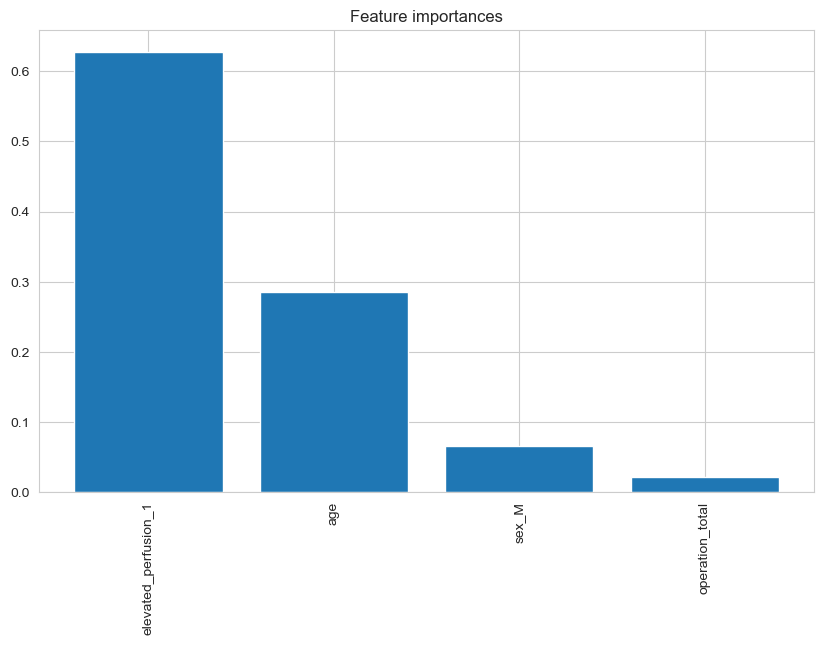

In [18]:
# Add the new feature to the list of features
features = ['sex', 'age', 'operation', 'elevated_perfusion']

X = patient_data[features]
y = patient_data[target]

# Pipeline for numerical features
numeric_features = ['age']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Pipeline for categorical features
categorical_features = ['sex', 'operation', 'elevated_perfusion']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Apply the transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Create the Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
random_forest.fit(X_train_transformed, y_train)

# Extract the feature importances from the trained model
importances = random_forest.feature_importances_

# Get the feature names from the preprocessor
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine the two lists
features = np.concatenate([numeric_features, categorical_features])
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# print mse and mae
y_pred = random_forest.predict(X_test_transformed)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the feature importances as a bar chart
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.show()

In [ ]:
# Get the index of the rcbv_ratio feature in the transformed dataset
feature_idx = list(features).index('rcbv_ratio')

# Create the PartialDependenceDisplay
display = PartialDependenceDisplay.from_estimator(
    random_forest, X_train_transformed, features=[feature_idx])

## Now let's repeat the same process for the synthetic dataset

In [73]:
synth_data = pd.read_csv('treatment.csv')
synth_data.head()

,r_d,theta,repetition,kappa,genetic_entropy,phenotype_entropy,rectime
0,0.0,0.0,0,-1.635913,2.687159,0.694025,129.0
1,0.0,0.0,1,-0.865879,2.060866,0.807282,154.0
2,0.0,0.0,2,-1.545359,2.737255,0.758394,140.0
3,0.0,0.0,3,-1.495602,2.615735,0.744453,165.0
4,0.0,0.0,4,-1.837688,2.675741,0.650427,122.0


In [85]:
# Define the features and the target variable
features = ['kappa', 'theta', 'r_d']
target = 'rectime_clean'

# Check for NaN values in 'rectime'
synth_data['rectime_clean'] = synth_data['rectime'].copy()
nan_rectime = synth_data['rectime'].isna()

# If there are any NaN values, replace them with the maximum of 'rectime'
if nan_rectime.sum() > 0:
    max_rectime = synth_data['rectime'].max()
    synth_data['rectime_clean'].fillna(max_rectime, inplace=True)
    
X = synth_data[features]
y = synth_data[target]


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize the Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model on the training data
random_forest.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = random_forest.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 23787.826907575756
Mean Absolute Error (MAE): 73.40095959595958


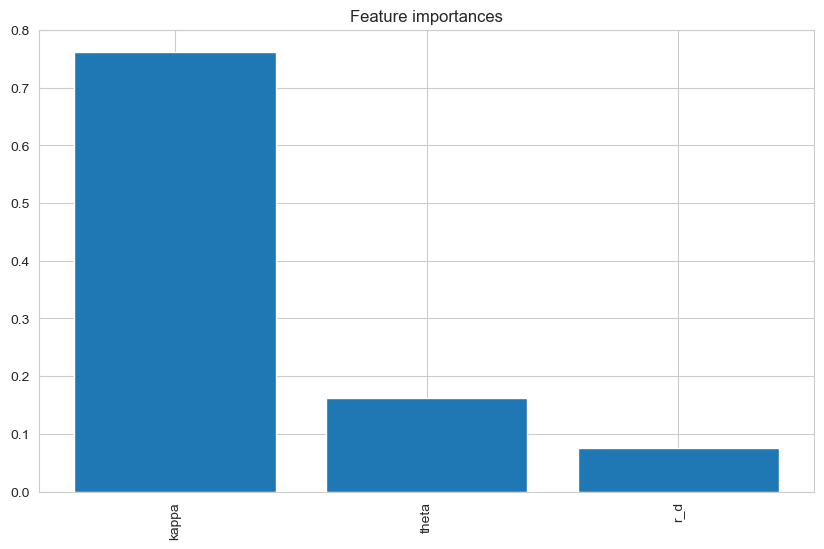

In [86]:
# Extract the feature importances from the trained model
importances = random_forest.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances as a bar chart
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), np.array(features)[indices], rotation=90)
plt.show()

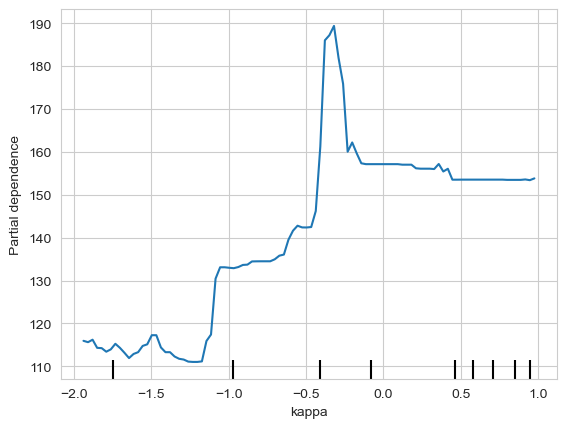

In [91]:
# Get the index of the rcbv_ratio feature in the transformed dataset
feature_idx = list(features).index('kappa')

# Create the PartialDependenceDisplay
display = PartialDependenceDisplay.from_estimator(
    random_forest, X_train_transformed, features=[feature_idx], feature_names=features)

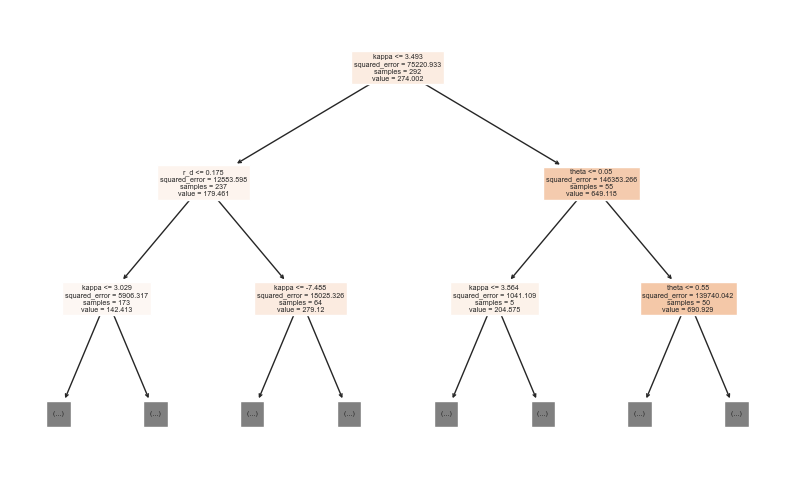

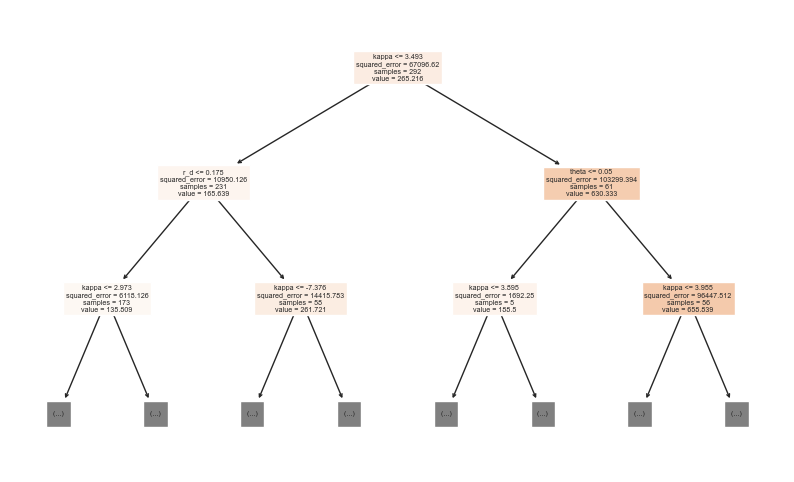

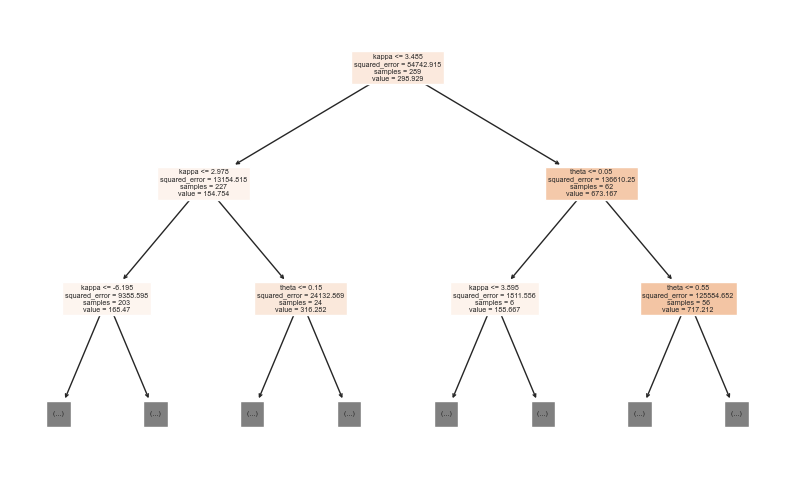

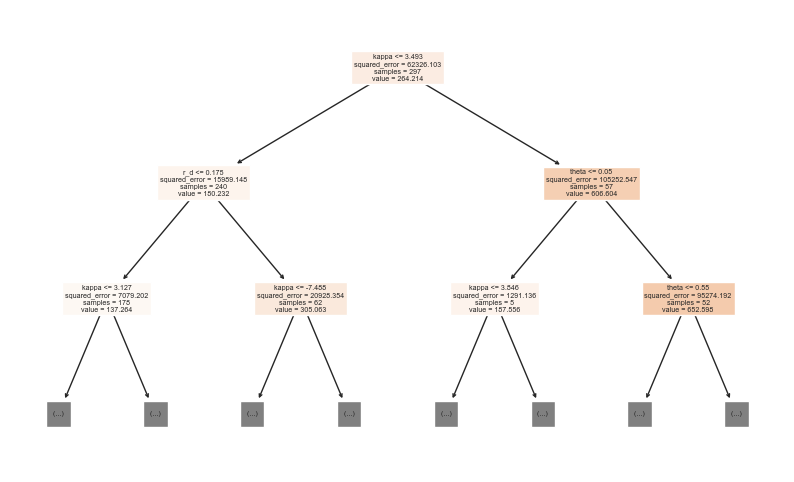

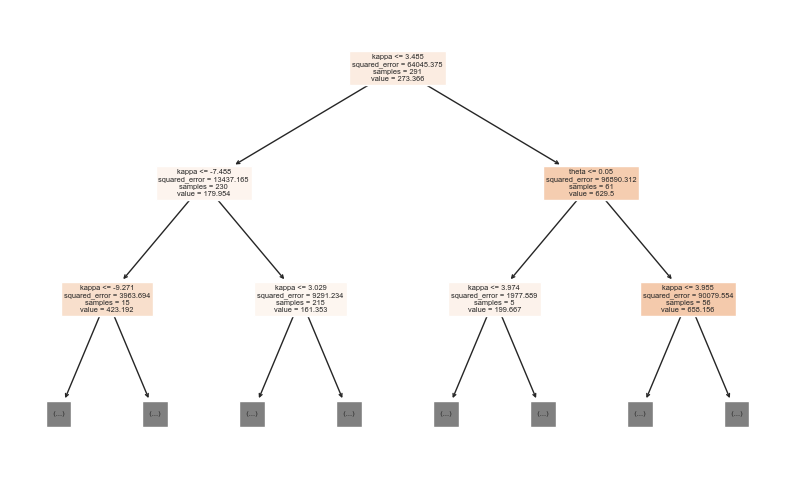

In [94]:
# Get the Random Forest model
model = random_forest
# Plot the first five trees
for i in range(5):
    plt.figure(figsize=(10, 6))
    plot_tree(model.estimators_[i], feature_names=list(features), filled=True, max_depth=2)
    plt.show()


In [ ]:
from sklearn.feature_selection import RFE

# Define the method
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=1)

# Fit the model
rfe = rfe.fit(X, y)

# Get the selected features
selected_features = rfe.support_

# Print the names of the selected features
print('Selected features:')
print(np.array(features)[selected_features])